In [ ]:
from climada.hazard import TCTracks
from climada.hazard import Centroids, TropCyclone

import exposures as ex
import impact as cimp
import bound_prot_dam as bpd
import haz_int_grd as hig
import set_nominal as snom
import alt_pay_opt as apo

import geopandas as gpd
import pandas as pd
import numpy as np

## Set-up CAT Bond

In [13]:
country = 308

#define minimum return period to be covered
lower_share = 0.064
#define maximum return period to be covered
upper_rp = 250

#define benchmark sharpe ratio
target_sharpe = 0.5

#define the risk free rate
rf_rate = 0.05

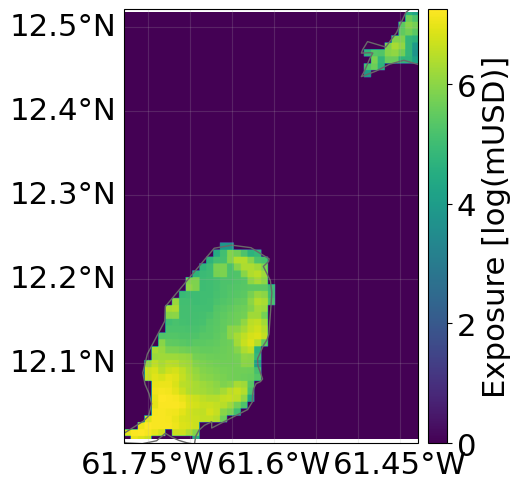

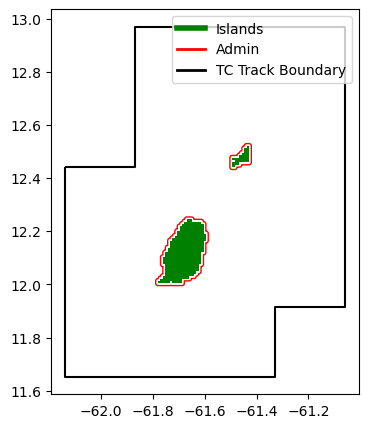

Number of tracks in NA basin: 2692


In [14]:
exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex.init_TC_exp(country, grid_size=600, buffer_size=1, load_fls=True)
imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf, plot_frequ=False) 
imp_per_event_flt, imp_admin_evt_flt, to_protect = bpd.init_imp_flt(imp_per_event, imp_admin_evt, prot_share=lower_share, exposure=exp)
int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_storms=tc_storms, stat='mean') 
nominal = snom.init_nominal(impact=imp, exposure=exp, prot_rp=upper_rp, print_nom=False)
result, optimized_step1, optimized_step2 = apo.init_alt_optimization(int_grid, nominal, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt, print_params=False)
pay_dam_df = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_step1, optimized_step2, int_grid, nominal, imp_admin_evt)

## Select Historic Event

c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:
<string>:6: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.


Text(0.5, 1.0, 'IVAN')

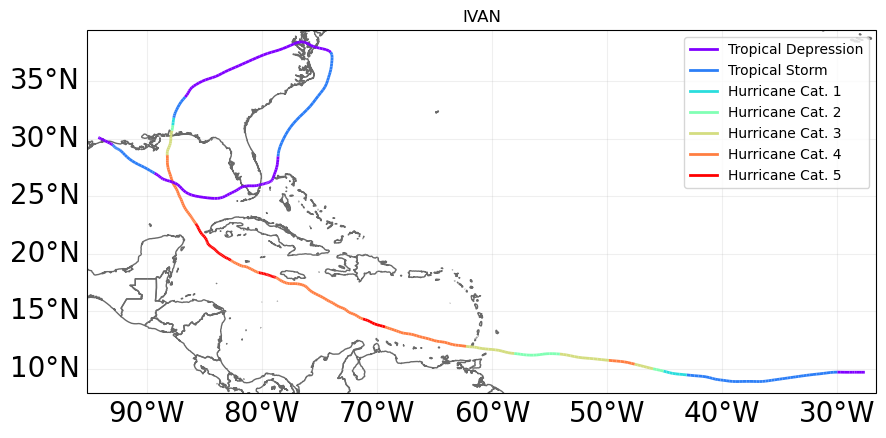

In [15]:
tr_test = TCTracks.from_ibtracs_netcdf(provider='usa', storm_id='2004247N10332', file_name='IBTrACS.ALL.v04r01.nc')
tr_test.equal_timestep(time_step_h=1)
ax = tr_test.plot()
ax.set_title('IVAN')

C:\Users\kaibe\AppData\Local\Temp\ipykernel_29480\3611226062.py:3: DeprecatedWarning: from_lat_lon is deprecated. This method will be removed in a future version. Simply use the constructor instead.
  centrs = Centroids.from_lat_lon(lat, lon)


<GeoAxes: title={'center': 'Event ID 1: 2004247N10332'}>

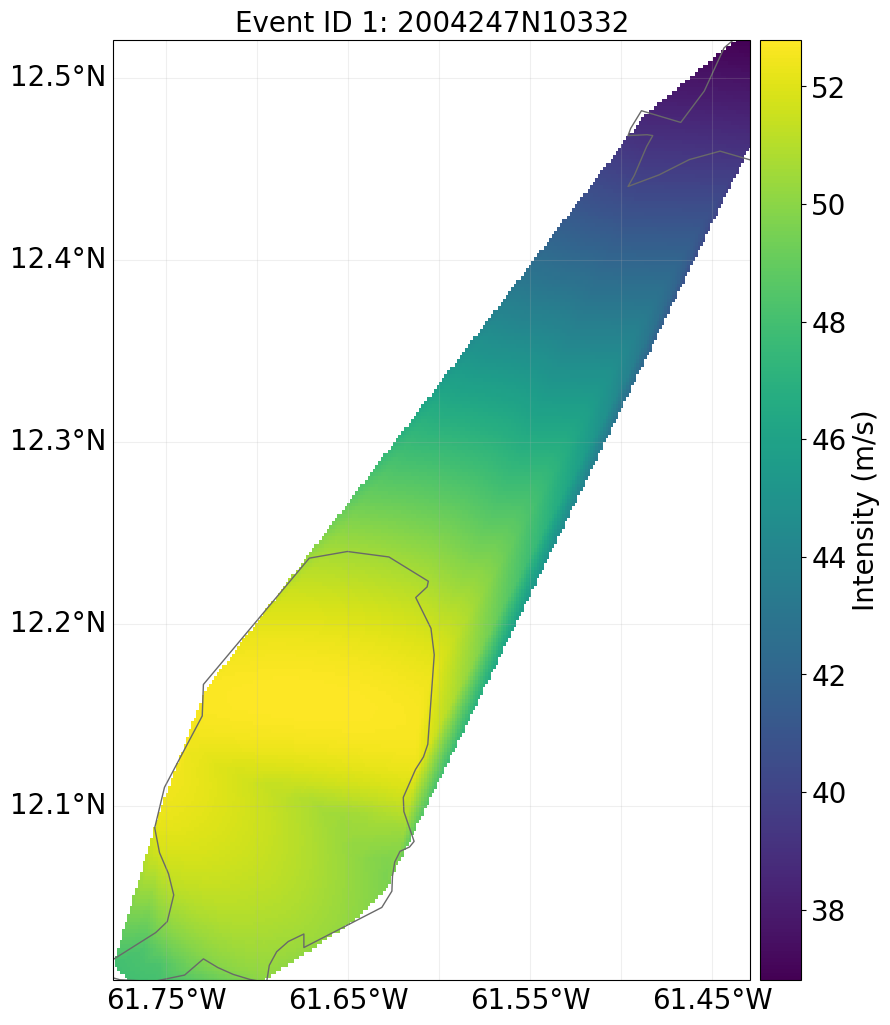

In [16]:
lat = exp.gdf['latitude'].values
lon = exp.gdf['longitude'].values
centrs = Centroids.from_lat_lon(lat, lon)

tc_test = TropCyclone.from_tracks(tr_test, centroids=centrs)
imp_test, imp_per_event_test, imp_admin_evt_test = cimp.init_imp(exp, tc_test, admin_gdf, plot_frequ=False)
tc_test.plot_intensity('2004247N10332')

## Check if Track is in TC Boundary

In [17]:
tc_tracks_lines = ex.to_geodataframe(tr_test)
intersected_tracks = gpd.sjoin(tc_tracks_lines, grid_gdf, how='inner', predicate='intersects')
select_tracks_test = tc_tracks_lines.index.isin(intersected_tracks.index)
print(select_tracks_test)

[ True]


c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  object.__setattr__(self, attr, val)


## Calculate Hazard Intensity per Grid

In [18]:
centrs_to_grid = tc_test.centroids.gdf.sjoin(admin_gdf, how='left', predicate="within")
agg_exp = centrs_to_grid.groupby('admin_letter').apply(lambda x: x.index.tolist())
#Initialize a dictionary to hold the calculated statistics
int_grid_test = {letter: [None] * len(tc_test.event_id) for letter in agg_exp.keys()}
#Iterate over each event
for i in range(len(tc_test.event_id)):
    #For each grid cell, calculate the desired statistic
    for letter, line_numbers in agg_exp.items():
        selected_values = tc_test.intensity[i, line_numbers]
        # Calculate the statistic based on the user's choice
        int_grid_test[letter][i] = selected_values.mean()

int_grid_test = pd.DataFrame.from_dict(int_grid_test)


## Calculate Payout

In [19]:
minimum_payout = imp_per_event_flt[imp_per_event_flt > 0].min()

for i in range(len(imp_per_event_flt)):
    tot_dam = imp_per_event_flt[i]
    pay_dam_df.loc[i,"damage"] = tot_dam
    payout = []
    for j in range(len(int_grid_test.columns)):
        min_trig = optimized_step1[j]
        max_trig = optimized_step2[j]
        grid_hazint = int_grid_test.iloc[0,j]
        max_dam = np.max(imp_admin_evt_flt.iloc[:,j])
        if max_dam < nominal:
            max_pay = max_dam
        else: 
            max_pay = nominal

        if grid_hazint >= max_trig:
            payout.append(max_pay)
        elif grid_hazint <= min_trig:
            payout.append(0)
        else:
            payout.append((grid_hazint - min_trig) / (max_trig - min_trig) * max_pay)

    tot_pay_test = np.sum(payout)
    if tot_pay_test > nominal:
        tot_pay_test = nominal
    elif tot_pay_test < minimum_payout:
        tot_pay_test = 0
    else: 
        pass

## Show Test Results

In [20]:
float(imp_per_event_test[0]) - tot_pay_test
print(f'Payout: {round(tot_pay_test, 0)} USD')
print(f'Damage: {round(imp_per_event_test[0], 0)} USD')
print(f'Basis Risk: {round(imp_per_event_test[0]-tot_pay_test, 0)} USD')
print(f'Basis Risk: {round(tot_pay_test/imp_per_event_test[0]*100, 0)}%')

Payout: 210383707.0 USD
Damage: 199772131.0 USD
Basis Risk: -10611575.0 USD
Basis Risk: 105.0%
